In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [5]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o")
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [7]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the 2024 us open")]})

{'messages': [HumanMessage(content='who is the winnner of the 2024 us open', additional_kwargs={}, response_metadata={}, id='8ddf13de-bf21-49a5-bf81-a3cc70056c79'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Jy9859ph5SJHiYlxRjoA1E3e', 'function': {'arguments': '{"query":"2024 US Open winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 98, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BRwOXiNY3SeW56KowCwq2z9PkAhQo', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-34130f4e-9ac9-4a2b-aeb3-3f5727e17c31-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query':

In [8]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [ ]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [10]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

In [11]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current year to determine the most recent Australia Open winner.', 'Research the winner of the Australia Open for the current year.', 'Find the hometown of the identified winner from the Australia Open.', 'The hometown identified in the previous step is the answer.'])

In [ ]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

In [13]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [14]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

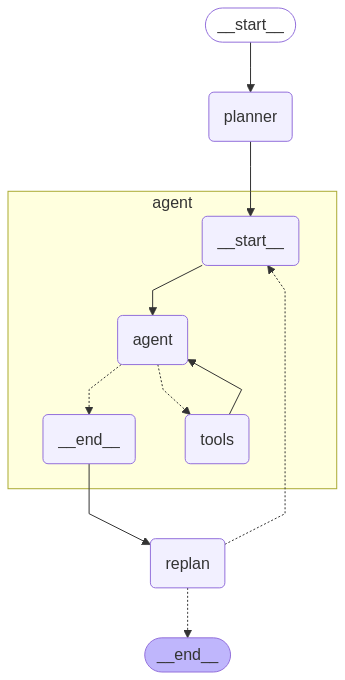

In [15]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [16]:
config = {"recursion_limit": 10}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Identify the winner of the men's 2024 Australian Open.", "Research the winner's personal background to find their hometown.", 'Verify the information from a reliable source to ensure accuracy.', "Conclude with the hometown of the men's 2024 Australian Open winner."]}
{'past_steps': [("Identify the winner of the men's 2024 Australian Open.", "The winner of the men's singles title at the 2024 Australian Open is Jannik Sinner.")]}
{'plan': ["Research Jannik Sinner's personal background to find his hometown.", 'Verify the information from a reliable source to ensure accuracy.', "Conclude with the hometown of the men's 2024 Australian Open winner."]}
{'past_steps': [("Research Jannik Sinner's personal background to find his hometown.", "Jannik Sinner's hometown is Sexten, a town located in the region of South Tyrol in northern Italy.")]}
{'response': "The plan has been successfully completed. The hometown of the men's 2024 Australian Open winner, Jannik Sinner, is Sexten, located

In [2]:
import openai, os
from dotenv import load_dotenv

load_dotenv()

client = openai.OpenAI(
    api_key=os.getenv("FIREWORKS_API_KEY"),
    base_url="http://localhost:8000"
    # base_url="https://api.fireworks.ai/inference/v1"
)

response = client.chat.completions.create(
    model="accounts/fireworks/models/qwen3-30b-a3b",
    messages=[
        {"role": "user", "content": "Hello, how are you?"}
    ],
    max_tokens=16384,
    top_p=1,
    temperature=0.6,
    frequency_penalty=0,
    presence_penalty=0,
    extra_body={"top_k": 40}  # Needed because top_k is not standard in OpenAI API
)

print(response.choices[0].message.content)
print(response)



Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help! How are you doing today? 😊
ChatCompletion(id='7f4584e6-90af-4392-ab3a-6e4d48b7abc0', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help! How are you doing today? 😊", refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning_content='Okay, the user greeted me with "Hello, how are you?" I should respond politely. I need to acknowledge their greeting and ask how they\'re doing. Let me make sure the response is friendly and open-ended. Maybe something like, "Hello! I\'m just a virtual assistant, so I don\'t have feelings, but I\'m here and ready to help! How are you doing today?" That sounds good. It\'s polite, acknowledges their question, and invites them to share their own status. I should check if ther

In [3]:

# 1. Define the function
def add_numbers(a: float, b: float):
    """Adds two numbers and returns the result."""
    return a + b

# Define a mapping of function names to function objects
available_functions = {
    "add_numbers": add_numbers,
}

# 2. Define the function schema
tools = [
    {
        "type": "function",
        "function": {
            "name": "add_numbers",
            "description": "Adds two numbers.",
            "parameters": {
                "type": "object",
                "properties": {
                    "a": {
                        "type": "number",
                        "description": "The first number to add.",
                    },
                    "b": {
                        "type": "number",
                        "description": "The second number to add.",
                    },
                },
                "required": ["a", "b"],
            },
        },
    }
]


In [4]:
import openai
import os
import json
from dotenv import load_dotenv

load_dotenv()

client = openai.OpenAI(
    api_key="fake",
    base_url="http://localhost:8000",    
    # api_key=os.getenv("FIREWORKS_API_KEY"),
    # base_url="https://api.fireworks.ai/inference/v1"
    # base_url="https://openrouter.ai/api/v1",
    # api_key=os.getenv("OPEN_ROUTER_KEY"),
)

# 3. Include the function schema in the API call


# Initial message
messages = [{"role": "user", "content": "What is 15 + 27?"}]

response = client.chat.completions.create(
    model="accounts/fireworks/models/qwen3-30b-a3b", # Or a function-calling capable model if available and different
    # model="qwen/qwen3-30b-a3b",
    messages=messages,
    tools=tools, # Add the tools parameter here
    tool_choice="auto", # 'auto' lets the model decide whether to call a function
    max_tokens=16384,
    top_p=1,
    temperature=0.6,
    frequency_penalty=0,
    presence_penalty=0,
    extra_body={"top_k": 40}
)

# 4. Process the model's response
response_message = response.choices[0].message

# Add the assistant's response to messages for potential follow-up turns
messages.append(response_message)
print(response_message)


ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_95838336194f42bca990ad46', function=Function(arguments='{"a": 15, "b": 27}', name='add_numbers'), type='function')], reasoning_content='Okay, the user is asking what 15 plus 27 is. Let me think. The question is straightforward, just adding two numbers. The tools provided include a function called add_numbers which takes two parameters, a and b. So I need to call that function with 15 and 27 as the arguments. The parameters are numbers, so I should make sure they\'re correctly formatted as numbers in the JSON. Let me check the function signature again. The function\'s parameters are "a" and "b", both numbers. The user\'s question is a simple addition, so there\'s no need for any other functions. I\'ll generate the tool call with the name add_numbers and the arguments a=15 and b=27.')


In [21]:
import openai
import os
import json
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = openai.OpenAI(
    api_key="fake",
    base_url="http://localhost:8000",
    # api_key=os.getenv("FIREWORKS_API_KEY"),
    # base_url="https://api.fireworks.ai/inference/v1"
    # base_url="https://openrouter.ai/api/v1",
    # api_key=os.getenv("OPEN_ROUTER_KEY"),
)

# Define tools (function definitions)
tools = [
    {
        "type": "function",
        "function": {
            "name": "calculate",
            "description": "Calculate the result of a mathematical operation",
            "parameters": {
                "type": "object",
                "properties": {
                    "operation": {
                        "type": "string",
                        "description": "The mathematical operation to perform",
                        "enum": ["add", "subtract", "multiply", "divide"]
                    },
                    "a": {
                        "type": "number",
                        "description": "The first number"
                    },
                    "b": {
                        "type": "number",
                        "description": "The second number"
                    }
                },
                "required": ["operation", "a", "b"]
            }
        }
    }
]

# Initial message
messages = [{"role": "user", "content": "What is 15 + 27?"}]

# Create a streaming chat completion
stream = client.chat.completions.create(
    model="accounts/fireworks/models/qwen3-30b-a3b",  # Or a function-calling capable model
    messages=messages,
    tools=tools,
    tool_choice="auto",  # 'auto' lets the model decide whether to call a function
    max_tokens=16384,
    top_p=1,
    temperature=0.6,
    frequency_penalty=0,
    presence_penalty=0,
    extra_body={"top_k": 40},
    stream=True  # Enable streaming
)

# Process the streaming response
collected_messages = []
function_call_content = ""
is_function_call = False

for chunk in stream:
    # print (chunk)
    # Check if this chunk contains a function call
    if chunk.choices[0].delta.tool_calls:
        is_function_call = True
        # Get the first tool call (if it's the first chunk with a tool call)
        if function_call_content == "":
            print("Model is making a function call...")
        
        # Extract function call data from this chunk
        tool_call = chunk.choices[0].delta.tool_calls[0]
        
        # If this chunk contains function name
        if tool_call.function.name:
            function_name = tool_call.function.name
            print(f"Function: {function_name}")
        
        # If this chunk contains function arguments (partial or complete)
        if tool_call.function.arguments:
            function_call_content += tool_call.function.arguments
    
    # If it's a regular text chunk
    elif chunk.choices[0].delta.content:
        content = chunk.choices[0].delta.content
        print(content, end="", flush=True)
        collected_messages.append(content)

print()  # Add newline after streaming

# If there was a function call, parse and execute it
if is_function_call:
    print("\nFunction call arguments:", function_call_content)
    try:
        args = json.loads(function_call_content)
        
        # Process the function call (example implementation)
        if args["operation"] == "add":
            result = args["a"] + args["b"]
        elif args["operation"] == "subtract":
            result = args["a"] - args["b"]
        elif args["operation"] == "multiply":
            result = args["a"] * args["b"]
        elif args["operation"] == "divide":
            result = args["a"] / args["b"]
        
        print(f"Function result: {result}")
        
        # Continue the conversation with the function result
        messages.append({
            "role": "assistant",
            "content": None,
            "tool_calls": [{
                "id": "call_123",  # You might want to generate a unique ID here
                "type": "function",
                "function": {
                    "name": "calculate",
                    "arguments": function_call_content
                }
            }]
        })
        
        # Add the function response to the messages
        messages.append({
            "role": "tool",
            "tool_call_id": "call_123",
            "content": str(result)
        })
        
    except json.JSONDecodeError:
        print("Error: Couldn't parse function arguments as JSON")
else:
    # Complete message obtained from stream
    complete_message = "".join(collected_messages)
    print("\nComplete message:", complete_message)
    
    # Add the assistant's response to messages for potential follow-up turns
    messages.append({"role": "assistant", "content": complete_message})



Model is making a function call...
Function: calculate
Model is making a function call...


Function call arguments: {"operation": "add", "a": 15, "b": 27}
Function result: 42


In [17]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("OPEN_ROUTER_KEY"),
)

completion = client.chat.completions.create(
  extra_body={},
  model="qwen/qwen3-30b-a3b:free",
  messages=[
    {
      "role": "user",
      "content": "Hello"
    }
  ]
)
print(completion.choices[0].message.content)

Hello! How can I assist you today? 😊


In [ ]:
completion

ChatCompletion(id='gen-1746197188-K6DkNbpjnotOsra7rid6', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today? 😊', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning='Okay, the user just said "Hello". That\'s pretty straightforward. I need to respond in a friendly and helpful manner. Let me think about the best way to greet them back.\n\nFirst, I should acknowledge their greeting. Maybe say "Hello!" to be polite. Then, offer assistance. People often use chatbots to ask questions or get help, so it\'s good to invite them to ask anything. I should keep it simple and open-ended.\n\nWait, the user might be testing the response or just starting a conversation. I should make sure my reply is welcoming. Maybe add an emoji to keep it friendly. Let me check the tone. No need for any markdown, just plain text. Alright, something like "Hello! How can I assist